#                          Regression Assignment

# 1. Imports and data loading

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR  # a scalable linear SVM regressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import os

# Fetch the dataset (this will download on first run if not cached)
cal = fetch_california_housing(as_frame=True)
df = cal.frame.copy()
df['MedHouseVal'] = cal.target

print("Data shape:", df.shape)
df.head()

Data shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


##  Preprocessing steps 

- **Missing values:** We check for missing values. The California dataset usually has no missing values.
- **Train-test split:** We'll use an 80/20 train/test split to evaluate performance on unseen data.
- **Feature scaling:** StandardScaler (mean=0, std=1) is applied for models that require it:
  - **Necessary** for Linear Regression and Support Vector Machines (they rely on distances and gradient-based optimizers).
  - **Not required** for tree-based models (Decision Tree, Random Forest, Gradient Boosting) because they are scale-invariant.

# 2. Preprocessing: check missing values, split, and scale where needed

In [8]:

print("Missing values (total):", df.isnull().sum().sum())

X = df.drop(columns=['MedHouseVal'])
y = df['MedHouseVal']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# applying scaling inside pipelines
scaler = StandardScaler()

Missing values (total): 0


## Algorithms used

1. **Linear Regression**
   - Fits a linear combination of features to predict the target.
   - Suitable as a baseline. Works well if relationship is approximately linear.

2. **Decision Tree Regressor**
   - Splits feature space into regions with constant predictions (conditional rules).
   - Handles non-linearities and interactions; prone to overfitting if not pruned/limited.

3. **Random Forest Regressor**
   - Ensemble of decision trees using bootstrap aggregation (bagging).
   - Reduces variance vs single tree and handles non-linear relationships well. Often strong on tabular data.

4. **Gradient Boosting Regressor**
   - Sequentially builds trees to correct previous errors (boosting).
   - Powerful, often best-in-class when tuned; can capture complex patterns.

5. **Support Vector Regressor (SVR) — Linear variant used here**
   - SVR finds a function within an epsilon-tube that approximates the target. LinearSVR uses a linear kernel and is faster.
   - Scaling required. Non-linear SVR (RBF) can be powerful but may be slow on larger N.

# 3. Define models, train/evaluate

In [9]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    # Using LinearSVR (linear SVM regressor) for performance. If you want non-linear SVR, replace with SVR(kernel='rbf').
    "Linear SVR": LinearSVR(random_state=42, max_iter=10000, tol=1e-4)
}

results = []
fitted_models = {}

for name, model in models.items():
    if name in ["Linear Regression", "Linear SVR"]:
        # Use a pipeline to ensure scaling is fitted on training set and applied to test set.
        pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        fitted_models[name] = pipe
    else:
        # Tree-based: scaling not required
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fitted_models[name] = model

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "MSE": mse, "MAE": mae, "R2": r2})

results_df = pd.DataFrame(results).set_index("Model").round(4)
results_df

,MSE,MAE,R2
Model,,,
Linear Regression,0.5559,0.5332,0.5758
Decision Tree,0.4952,0.4547,0.6221
Random Forest,0.2554,0.3275,0.8051
Gradient Boosting,0.2940,0.3716,0.7756
Linear SVR,0.5866,0.5117,0.5523


# 4. Visual comparison - R2 and MSE barplots

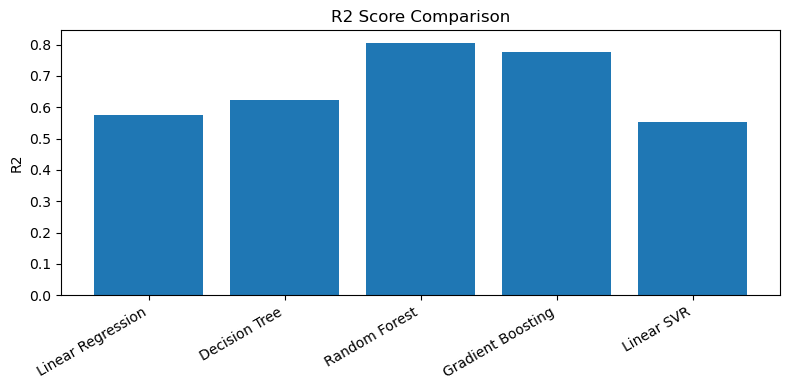

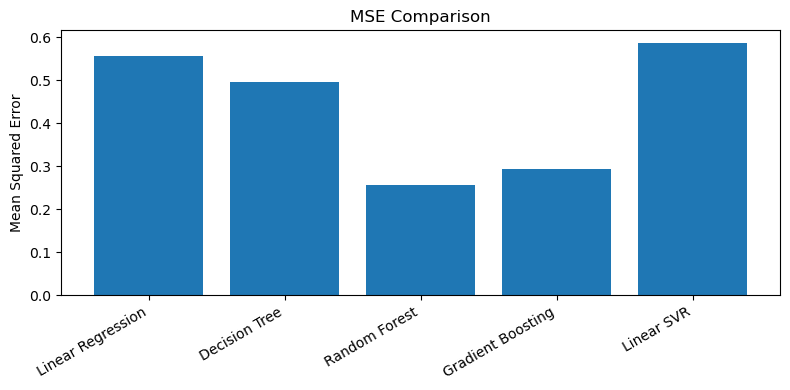

In [10]:
plt.figure(figsize=(8,4))
plt.bar(results_df.index, results_df['R2'])
plt.title("R2 Score Comparison")
plt.ylabel("R2")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.bar(results_df.index, results_df['MSE'])
plt.title("MSE Comparison")
plt.ylabel("Mean Squared Error")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

## Expected outcomes

- **Expected best:** Usually *Random Forest* or *Gradient Boosting* perform best on house-price like tabular datasets(Highest R2 and lowest MSE) because they capture non-linear relationships and feature interactions and are robust to feature scaling issues.
- **Expected worst:** Often *Linear Regression* or *Linear SVR* (lowest R2 and highest MSE)if the true relationships are non-linear. A single Decision Tree may also perform poorly due to overfitting on training data.